# Homework 7

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

### Utilities

In [2]:
class YokoiConnectivity():
    def __init__(self, connectivity='4-connectivity'):
        self.connectivity = connectivity
        self.map = { 'r': 0, 'q': 1, 's': 2 }
        
    def process(self, img):
        """
        Arguments:
            img: MxN numpy array

        Returns:
            yokoi_matrix : MxN numpy array

        """
        yokoi_matrix = np.zeros(img.shape, dtype='int')
        
        # Expand the original image with 0s
        n_rows, n_cols = img.shape
        expanded_img = np.zeros((n_rows+2, n_cols+2), dtype='uint8')
        expanded_img[1: n_rows+1, 1: n_cols+1] = img
        
        for i in range(1, n_rows+1):
            for j in range(1, n_cols+1):
                if expanded_img[i, j] == 0: continue
                
                # Get the region types of 4 corners
                corner_region_types = self.get_region_types(expanded_img[i-1: i+2, j-1: j+2])
                
                # Calculate the yokoi number
                yokoi_matrix[i-1, j-1] = self.yokoi_f(corner_region_types)
        
        return yokoi_matrix

    def get_region_types(self, region):
        """
        Arguments:
            region: 3x3 numpy array
        
        Returns:
            corner_region_types: 4x1 numpy array
        
        """
        x7, x2, x6, x3, x0, x1, x8, x4, x5 = region.flatten()
        
        corner_region_types = np.zeros(4)
        corner_region_types[0] = self.get_region_type((x0, x1, x6, x2))
        corner_region_types[1] = self.get_region_type((x0, x2, x7, x3))
        corner_region_types[2] = self.get_region_type((x0, x3, x8, x4))
        corner_region_types[3] = self.get_region_type((x0, x4, x5, x1))
        
        return corner_region_types
                
    def get_region_type(self, region):
        """
        Arguments:
            region: 4-tuple (x0, main_axis, .., ..)
        
        Returns:
            region_type: int (stands for r, q or s)
            
        """
        x0, x1, x2, x3 = region
        if x1 == x0 and x2 == x0 and x3 == x0:
            return self.map['r']
        elif x1 == x0:
            return self.map['q']
        
        return self.map['s']
    
    def yokoi_f(self, corner_region_types):
        """
        Arguments:
            corner_region_types: 4x1 numpy array
        
        Returns:
            yokoi_connectivity_number: int
            
        """
        if (corner_region_types == self.map['r']).sum() == 4:
            return 5
        
        return (corner_region_types == self.map['q']).sum()     

### Original image

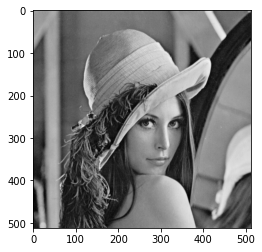

In [3]:
img = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.show()

### Downsampled binary image

In [4]:
def binarize(img):
    return (img >= 128) * 255

In [5]:
def downsample(img):
    return img[::8, ::8]

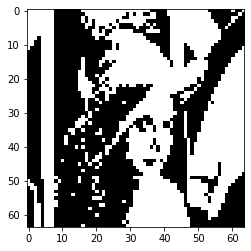

In [6]:
binary_img = downsample(binarize(img))
plt.imshow(binary_img, cmap='gray')
plt.show()

### Thinning

In [7]:
class PairRelationship():
    def __init__(self, ref_type='yokoi'):
        self.PROCESS_FUNC = {
            'yokoi': self.process_on_yokoi
        }
        self.process_func = self.PROCESS_FUNC[ref_type]
        self.map = { 'n': -1, 'q': 0, 'p': 1 }
    
    def process(self, ref):
        """
        Arguments:
            ref: MxN numpy array
            
        Returns:
            pair_relationship
        """
        pair_relationship_matrix = np.zeros(ref.shape, dtype='int')
        
        # expand the original reference with 0s
        n_rows, n_cols = ref.shape
        expanded_ref = np.zeros((n_rows+2, n_cols+2), dtype='int')
        expanded_ref[1: n_rows+1, 1: n_cols+1] = ref
        
        for i in range(1, n_rows+1):
            for j in range(1, n_cols+1):
                pair_relationship_matrix[i-1, j-1] = self.process_func(expanded_ref[i-1: i+2, j-1: j+2])
        
        return pair_relationship_matrix
    
    def process_on_yokoi(self, region):
        """
        Arguments:
            region: 3x3 numpy array
            
        Returns:
            pair_relationship: int (stands for p or q)
            
        """
        _, x1, _, x2, x0, x3, _, x4, _  = region.flatten()
        
        if x0 == 0:
            return self.map['n']
        
        if not x0 == 1:
            return self.map['q']
        
        if (np.array([x1, x2, x3, x4]) == 1).sum() >= 1:
            return self.map['p']
        
        return self.map['q']

In [8]:
class Thinning():
    def __init__(self, connectivity='4-connectivity'):
        self.connectivity = connectivity
    
    def process(self, img, return_semi=False):
        """
        Arguments:
            img: MxN numpy array
            return_semi: bool

        Returns:
            thinned_img : MxN numpy array
            semi_thinned_img: CxMxN numpy array (return only when return_semi is True)

        """
        semi_thinned_img = []
        thinned_img = np.copy(img)
        
        # Expand the original image with 0s
        n_rows, n_cols = img.shape
        expanded_img = np.zeros((n_rows+2, n_cols+2), dtype='uint8')
        expanded_img[1: n_rows+1, 1: n_cols+1] = img
        
        while True:
            # Step 1: Compute Yokoi matrix
            yokoi = YokoiConnectivity()
            yokoi_matrix = yokoi.process(thinned_img)
            
            # Step 2: Generate marked image via pair relationship on Yokoi matrix
            pair_relationship = PairRelationship()
            pair_relationship_matrix = pair_relationship.process(yokoi_matrix)
            
            # Step 3: Thin the image according to the marked image and connected shrink operator
            for i in range(1, n_rows+1):
                for j in range(1, n_cols+1):
                    if not pair_relationship_matrix[i-1, j-1] == 1: continue
                    
                    corner_region_types = yokoi.get_region_types(expanded_img[i-1: i+2, j-1: j+2])
                    if (corner_region_types == 1).sum() == 1:
                        expanded_img[i, j] = 0
            
            thinned_img = expanded_img[1: n_rows+1, 1: n_cols+1]
            
            if len(semi_thinned_img) == 0 or not (thinned_img == semi_thinned_img[-1]).sum() == n_rows * n_cols:
                semi_thinned_img.append(np.copy(thinned_img))
            else:
                break
        
        if return_semi:
            return thinned_img, np.array(semi_thinned_img)
        
        return thinned_img
        

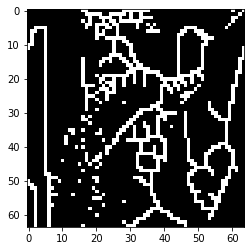

In [9]:
thinning = Thinning()
thinned_img, semi_thinned_imgs = thinning.process(binary_img, return_semi=True)
plt.imshow(thinned_img, cmap='gray')
plt.show()

In [10]:
thinned_imgs = [Image.fromarray(thin_img) for thin_img in np.append(semi_thinned_imgs, np.array([thinned_img]), axis=0)]
thinned_imgs[0].save("thinning.gif", save_all=True, append_images=thinned_imgs[1:], duration=500, loop=0)

<img src="thinning.gif" alt="thinning" width="256"/>